In [1]:
%matplotlib inline
import numpy as np
import pylab as pl
import matplotlib

matplotlib.rc('font', family='sans')
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['font.family'] = 'CMU Sans Serif'

In [2]:
from matplotlib import ticker

import pyfits
import numpy as np
import pylab as pl
import scipy.interpolate
from matplotlib.patches import *
pl.rcParams['figure.figsize'] = (7, 5.0)
pl.rcParams['font.size'] = 20
#pl.rcParams['font.family'] = 'serif'

path = "/Users/jmsantander/veritas/icecube/ic_nu20/"
#filename = path + "L180311235122DDDE4FF397_PH00.fits"
#filename = path + "L180314112860DB8A4EBB17_PH00.fits"
filename = "L180314112860DB8A4EBB17_PH00.fits"

hdulist = pyfits.open(filename)
h, data, columns = hdulist[1].header, hdulist[1].data, hdulist[1].columns

# Source position - IC_NU20
#RA0 = 110.34
#DEC0 = 11.48

RA0=77.3582
DEC0=5.69315

def pol2vec(ra, dec):
    phi = (360 - ra) * np.pi / 180.
    theta = (90 - dec) * np.pi / 180.

    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)

    r = np.sqrt(x**2 + y**2 + z**2)

    return (x/r, y/r, z/r)

def MET2MJD(met):
    MJDREF = 51910.0 + 7.428703703703703E-4;
    return (met/86400.) + MJDREF

def dotprod(a, b):
    return a[0] * b[0] + a[1] * b[1] + a[2] * b[2]

def openingAngle(ra1, dec1, ra2, dec2):
    a = pol2vec(ra1, dec1)
    b = pol2vec(ra2, dec2)

    dp = dotprod(a,b)
    return np.arccos(dp) * 180. / np.pi


def getMETnow():
    from datetime import datetime, timedelta
    d = datetime(2001,1,1,0,0,0)
    a = (datetime.utcnow()-d)
    return a.total_seconds()

/Users/up/miniconda3/lib/python3.6/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


(58188, 58206.54547257602)

/Users/up/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['CMU Sans Serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


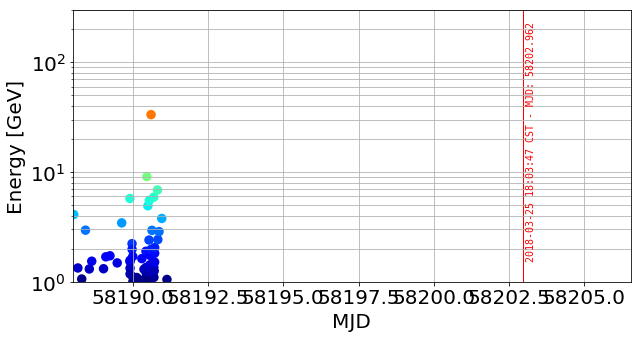

In [3]:
def getContAngle95Function():
    # Files
    frontfile = "p7rep_95contangle_front.csv"
    backfile = "p7rep_95contangle_back.csv"

    frontdata = np.genfromtxt(frontfile, delimiter=',')
    backdata = np.genfromtxt(backfile, delimiter=',')

    ffront = scipy.interpolate.interp1d(frontdata[:,0],frontdata[:,1], kind='linear', bounds_error=False, fill_value=frontdata[:,1][-1])
    fback = scipy.interpolate.interp1d(backdata[:,0],backdata[:,1], kind='linear', bounds_error=False, fill_value=backdata[:,1][-1])

    return (ffront, fback)


f = getContAngle95Function() # containment angle interpolation

# get the containment angle for each event
cont_angle = []

for event in data:
    energyEvent = event['ENERGY']
    conv_type = event['CONVERSION_TYPE']

    cont_angle.append(f[conv_type](energyEvent))

METnow = getMETnow()
mjdnow = MET2MJD(METnow)

contdata = data[(openingAngle(RA0, DEC0, data['RA'], data['DEC']) < cont_angle) & (data['ENERGY'] > 1000)  ]
notcontdata = data[(openingAngle(RA0, DEC0, data['RA'], data['DEC']) >= cont_angle) & (data['ENERGY'] > 1000) ]


fig1 = pl.figure(figsize=(10,5))
ax = fig1.add_subplot(111)

time = contdata['TIME']
energy = contdata['ENERGY']/1e3

ntime = notcontdata['TIME']
nenergy = notcontdata['ENERGY']/1e3

x_format = matplotlib.ticker.ScalarFormatter(useOffset=False)

ax.set_yscale('log')
ax.scatter(MET2MJD(time),energy,c=np.log10(energy),cmap=matplotlib.cm.jet, edgecolor='none', s=90)
ax.set_ylim(1,300)
ax.set_xlabel('MJD')
ax.xaxis.set_major_formatter(x_format)
ax.set_ylabel('Energy [GeV]')
ax.grid(True,which='both')

from datetime import datetime, timedelta
d = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
datestr = d + " CST - MJD: " + "{0:.3f}".format(mjdnow)
ax.text(mjdnow+0.1,200, datestr, rotation=90, color='red', size=10, family='monospace')
ax.axvspan(mjdnow,mjdnow, color='red')

ax.set_xlim(58188,)



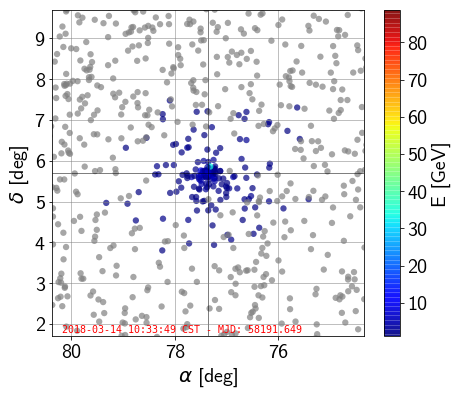

In [6]:
fig2 = pl.figure(figsize=(7,6))
ax2 = fig2.add_subplot(111)
sc = ax2.scatter(contdata['RA'], contdata['DEC'], c=energy, cmap=matplotlib.cm.jet, s=40, edgecolor='none', alpha=0.7)
ax2.scatter(notcontdata['RA'], notcontdata['DEC'], c="gray", s=40, edgecolor='none', alpha=0.7)
#ax2.scatter([RA0], [DEC0], edgecolor='gray', s=350, color='none', linewidth=2)
ax2.axhspan(DEC0, DEC0, color='black', linewidth=0.5)
ax2.axvspan(RA0, RA0, color='black', linewidth=0.5)
ax2.set_xlabel(r'$\alpha$ [deg]')
ax2.set_ylabel(r'$\delta$ [deg]')
ax2.grid(True,which='both', color='gray', linewidth=0.5)
cb = pl.colorbar(sc)
dRA = 3 / np.cos(DEC0 * np.pi / 180.)
dDec = 4
ax2.set_xlim(RA0+dRA,RA0-dRA)
ax2.set_ylim(DEC0-dDec,DEC0+dDec)
ax2.text(RA0+dRA-0.2, DEC0-dDec+0.1, datestr, color='red', size=10, family='monospace')
cb.set_label("E [GeV]")